In [48]:
import pandana as pdna
import pandas as pd
import geopandas as gpd

import matplotlib
from matplotlib import pyplot as plt

Before running this notebook, first create the combined transit network using the notebook create_access_network.ipynb

# Create the Pandana network

In [7]:
nodes=pd.read_csv('./outputs/networks/nodes.csv', index_col=0)
edges=pd.read_csv('./outputs/networks/edges.csv', index_col=0)

/opt/anaconda3/envs/ntt/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (2,3,5,7,9,10,12,13,14,15,16,17,18,19,20,21,23,24,25,26,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
transit_ped_net = pdna.Network(nodes["x"],
                               nodes["y"],
                               edges["from_int"],
                               edges["to_int"],
                               edges[["weight"]], 
                               twoway=False)

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 83889
Setting CH edge vector of size 361053
Range graph removed 476004 edges of 722106
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


# Get the POI Data

In [24]:
ACCOMODATION_DATA_LOC='https://dati.comune.roma.it/catalog/dataset/d51c988e-3e09-4175-9f6f-d3d61599417d/resource/d711888d-c4fb-4988-9a21-7783d65425c5/download/suar2021-08.csv'

In [40]:
accommodation=pd.read_csv(ACCOMODATION_DATA_LOC, sep=';')

In [41]:
accommodation.head()

,id,tipologia,denominazione,via,civico,latitude,longitude,stelle,categoria,totalePostiLetto,...,spaccio,campiBocce,campoBeachVolley,campoCalcetto,campoPallavolo,attraccoNatanti,numeroBungalow,numeroDocce,numeroLavadini,numeroPiazzole
0,338189,Guest House o Affittacamere,00146 ROMA HOLIDAY AND JUBILEE HOUSE,Via Efeso,19,41.854266,12.474979,NaN,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,336739,Guest House o Affittacamere,126 GRACCHI SUITES GUEST HOUSE O AFFITTACAMERE,Via dei Gracchi,126,41.908495,12.463876,NaN,2.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,335666,Guest House o Affittacamere,149 GUEST HOUSE,Via Marmorata,149,41.881459,12.476980,NaN,2.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,336886,Guest House o Affittacamere,1880 ATYPICAL ROOMS,Via Nazionale,66,41.899339,12.491388,NaN,2.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,337239,Guest House o Affittacamere,19 STEPS TREVI GUEST HOUSE O AFFITTACAMERE,Via dei Crociferi,26,41.900808,12.481812,NaN,3.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
accommodation.groupby('tipologia').size()

tipologia
Agriturismi                          23
Alberghi                            883
Alloggi per uso turistico          8332
Bed and Breakfast                  1413
Campeggi                             17
Case e appartamenti per vacanze    5418
Case per ferie                      246
Dipendenze alberghiere               67
Guest House o Affittacamere        2993
Ostelli per la gioventù              20
Residence                            33
dtype: int64

Remove entries with invalid lat and lon to avoid errors in pandana analysis

In [43]:
print(len(accommodation))
accommodation=accommodation.loc[
    ((~accommodation['longitude'].isnull())&
     (~accommodation['latitude'].isnull()))
]
print(len(accommodation))

19445
19411


<AxesSubplot:>

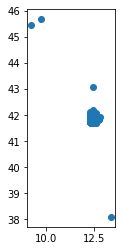

In [56]:
accommodation_gdf=gpd.GeoDataFrame(data=accommodation,geometry=gpd.points_from_xy(
    x=accommodation.longitude, 
    y=accommodation.latitude, 
    crs='EPSG:4326'))
accommodation_gdf.plot()

In [58]:
accommodation_gdf.to_file('./outputs/accomodation.geojson', 
                          driver='GeoJSON')

## Run accessibility calculations

In [44]:
max_minutes=15

In [60]:
accom_nodes = transit_ped_net.get_node_ids(accommodation['longitude'], 
                                   accommodation['latitude'])
transit_ped_net.set(accom_nodes, 
            name = 'accomodation')

accom_access = transit_ped_net.aggregate(distance = max_minutes,
                                  type = 'count',
                                  name = 'accomodation')
accom_access.describe()

count    83889.000000
mean       551.385271
std       1104.968470
min          0.000000
25%         13.000000
50%         68.000000
75%        377.000000
max       7622.000000
dtype: float64

In [66]:
# nodes_gdf.plot(column='accom_access')

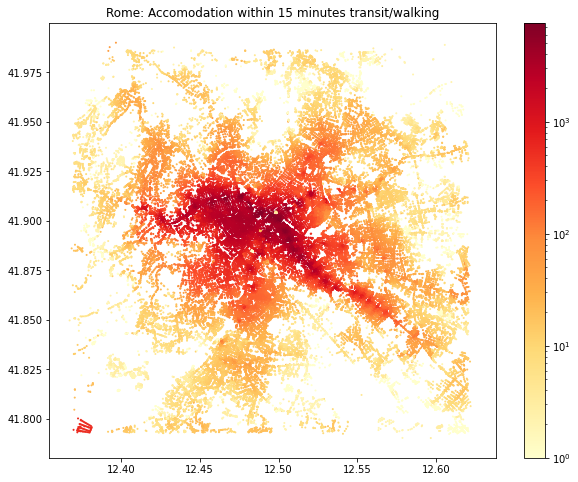

In [65]:
fig, ax = plt.subplots(figsize=(10,8))

plt.title('Rome: Accomodation within 15 minutes transit/walking')
plt.scatter(transit_ped_net.nodes_df.x, transit_ped_net.nodes_df.y, 
            c=accom_access, s=1, cmap='YlOrRd', 
            norm=matplotlib.colors.LogNorm())
cb = plt.colorbar()

plt.show()

In [67]:
nodes_gdf=gpd.GeoDataFrame(data={'accom_access': accom_access,
                                'x':transit_ped_net.nodes_df.x,
                                'y':transit_ped_net.nodes_df.y},
                           geometry=gpd.points_from_xy(
                               x=transit_ped_net.nodes_df.x, 
                               y=transit_ped_net.nodes_df.y, 
                               crs='EPSG:4326'))
nodes_gdf.to_file('./outputs/access/accom_access.geojson', 
                          driver='GeoJSON')